<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/KLUE_NLI/Korean_NLI_classification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch] datasets gluonnlp mxnet --quiet

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import os

from sklearn.metrics import confusion_matrix

import gluonnlp as nlp
import mxnet

import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

from transformers import (AutoTokenizer,
                          AutoModel,
                          AdamW,
                          TrainingArguments,
                          Trainer)
from transformers.optimization import get_cosine_schedule_with_warmup

from datasets import load_dataset

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
SEED = 42

In [4]:
dataset = load_dataset("klue", "nli", split="train")
split_dataset = dataset.train_test_split(0.2)
train_dataset = split_dataset['train']
valid_dataset = split_dataset['test']
test_dataset = load_dataset("klue", "nli", split="validation")

In [5]:
train_dataset

Dataset({
    features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
    num_rows: 19998
})

**Label**
* entailment : 0  
* neutral : 1  
* contradiction: 2

In [6]:
print('guid : ',train_dataset[0]['guid'])
print('source : ',train_dataset[0]['source'])
print('premise : ',train_dataset[0]['premise'])
print('hypothesis : ',train_dataset[0]['hypothesis'])
print('label : ',train_dataset[0]['label'])

guid :  klue-nli-v1_train_05172
source :  NSMC
premise :  느림의 미학을 잘 따라가줄 아는 사람에게는 명작일 듯한 작품
hypothesis :  일반인들에게는 졸작인 작품.
label :  1


In [7]:
valid_dataset

Dataset({
    features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
    num_rows: 5000
})

In [8]:
test_dataset

Dataset({
    features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
    num_rows: 3000
})

In [9]:
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
def making_text(examples):
  cls = tokenizer.cls_token
  sep = tokenizer.sep_token
  premise = str(examples['premise'])
  hyp = str(examples['hypothesis'])
  text = cls +' '+ premise +' '+  sep +' '+  hyp  +' '+ sep
  return {'combined': text}

In [11]:
train_added = train_dataset.map(making_text)
valid_added = valid_dataset.map(making_text)
test_added = test_dataset.map(making_text)

Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [12]:
train_added[0]

{'guid': 'klue-nli-v1_train_05172',
 'source': 'NSMC',
 'premise': '느림의 미학을 잘 따라가줄 아는 사람에게는 명작일 듯한 작품',
 'hypothesis': '일반인들에게는 졸작인 작품.',
 'label': 1,
 'combined': '[CLS] 느림의 미학을 잘 따라가줄 아는 사람에게는 명작일 듯한 작품 [SEP] 일반인들에게는 졸작인 작품. [SEP]'}

In [13]:
max_len = 128

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __getitem__(self, index):
    text = self.dataset[index]['combined']
    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=max_len,
        padding='max_length',
        add_special_tokens=False
    )
    input_ids = inputs['input_ids'][0]
    token_type_ids = inputs['token_type_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    label = self.dataset[index]['label']
    return input_ids, token_type_ids, attention_mask, label

  def __len__(self):
    return len(self.dataset)


In [14]:
train_dataset = CustomDataset(train_added, tokenizer)
valid_dataset = CustomDataset(valid_added, tokenizer)
test_dataset = CustomDataset(test_added, tokenizer)

In [15]:
BATCH_SIZE = 32

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testdloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# for idx, batch in enumerate(trainloader):
#   print(batch)
#   if idx==0:
#     break

In [17]:
bert_model = AutoModel.from_pretrained(MODEL_NAME, return_dict=False)
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [18]:
class BERTClassifier(nn.Module):
  def __init__(
      self,
      bert,
      hidden_size = 768,
      num_classes= 3,
      dropout = None,
      params = None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dropout = dropout

    self.classifier = nn.Linear(hidden_size, num_classes)

    if dropout:
      self.dropout = nn.Dropout(p=dropout)

  def forward(self, input_ids, token_type_ids, attention_mask):
    _, pooler = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)

    if self.dropout:
      output = self.dropout(pooler)
    else:
      output = pooler

    predicted = self.classifier(output)

    return predicted

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
warmup_ratio = 0.1
num_epochs = 1
max_grad_norm = 1
learning_rate =  5e-5

In [21]:
dropout_rate = 0.2

model = BERTClassifier(bert_model, dropout=dropout_rate).to(device)

In [22]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [23]:
def accuracy_matric(prediction, true_vals):
  max_vals, max_indicies = torch.max(prediction, 1)
  accuracy = (max_indicies == true_vals).sum().data.cpu().numpy()/max_indicies.size()[0]
  return accuracy

In [24]:
def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.colormaps.get_cmap('Blues')):
    plt.figure(figsize=(7,7))
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []

    for k in range(len(c_matrix)):
        n = sum(c_matrix[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)

    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = c_matrix.max() / 2.

    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
      plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [25]:
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
learning_rate =  5e-5

In [26]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [27]:
optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
total_steps = len(trainloader) * num_epochs
warmup_step = int(total_steps * warmup_ratio)

In [29]:
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_step,
                                            num_training_steps=total_steps)

In [30]:
def accuracy_metric(predictions, true_vals):
  max_vals, max_indicies = torch.max(predictions, 1)
  accuracy = (max_indicies == true_vals).sum().data.cpu().numpy()/max_indicies.size()[0]
  return accuracy

In [31]:
def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.colormaps.get_cmap('Blues')):
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []

    for k in range(len(c_matrix)):
        n = sum(c_matrix[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)

    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = c_matrix.max() / 2.

    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
      plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
class Trainer():
  def __init__(self, trainloader, validloader,  testdloader, model, optimizer, criterion, scheduler, device):
    self.trainloader = trainloader
    self.validloader  = validloader
    self.testdloader = testdloader
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler
    self.device = device

  def train(self, epochs = 1):
    self.model.train()

    best_acc = None
    for epoch in range(1, epochs+1):
      train_acc = 0.0
      running_loss =0.0
      print("==================Epoch {}/{}==================".format(epoch, epochs))
      for batch_idx, batch in tqdm(enumerate(self.trainloader), total=len(self.trainloader)):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':batch[0],
                  'token_type_ids':batch[1],
                  'attention_mask':batch[2]}
        label = batch[3]

        self.optimizer.zero_grad()
        predict = self.model(**inputs)
        loss = self.criterion(predict, label)
        running_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        self.optimizer.step()
        self.scheduler.step()

        train_acc += accuracy_metric(predict, label)

      train_loss = running_loss/len(trainloader)
      valid_acc = self.validate()
      tqdm.write('Train Loss: {:.4f}, Train Accuracy:{:.4f}, Valid Accuracy :{:.4f}'.format(train_loss, train_acc/(batch_idx+1), valid_acc))

      if best_acc is None or best_acc <= valid_acc:
        best_acc = valid_acc
      else:
        break

  def validate(self):
    self.model.eval()
    valid_acc = 0.0
    predictions, true_vals =[], []

    with torch.no_grad():
      running_loss = 0.0
      for batch_idx, batch in tqdm(enumerate(self.validloader), total=len(self.validloader)):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':batch[0],
              'token_type_ids':batch[1],
              'attention_mask':batch[2]}
        label = batch[3]

        predict = model(**inputs)
        valid_acc += accuracy_metric(predict, label)

      predicted_label = torch.max(predict, 1)[1]
      true_vals +=label.tolist()
      predictions += predicted_label.tolist()

    return valid_acc/(batch_idx+1)

  def test(self):
    self.model.eval()
    test_acc = 0.0
    predictions, true_vals =[], []

    with torch.no_grad():
      for batch_idx, batch in tqdm(enumerate(self.testdloader), total=len(self.testdloader)):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':batch[0],
                  'token_type_ids':batch[1],
                  'attention_mask':batch[2]}
        label = batch[3]
        predict = model(**inputs)
        test_acc += accuracy_metric(predict, label)

        predict_label = torch.max(predict, 1)[1]
        predictions += predict_label.tolist()
        true_vals +=label.tolist()

    print('Test accuracy:{:.4f}'.format(test_acc/(batch_idx+1)))

    test_confusion_matrix = confusion_matrix(predictions, true_vals)
    plot_confusion_matrix(test_confusion_matrix, labels=["entailment", "contradiction", "neutral"])

In [33]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  testdloader = testdloader,
                  model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  scheduler = scheduler,
                  device = device)
trainer.train(epochs=num_epochs)

==================Epoch 1/10==================


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.7396, Train Accuracy:0.6592, Valid Accuracy :0.7972
==================Epoch 2/10==================


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3951, Train Accuracy:0.8540, Valid Accuracy :0.8097
==================Epoch 3/10==================


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1611, Train Accuracy:0.9478, Valid Accuracy :0.8010


  0%|          | 0/94 [00:00<?, ?it/s]

Test accuracy:0.7832


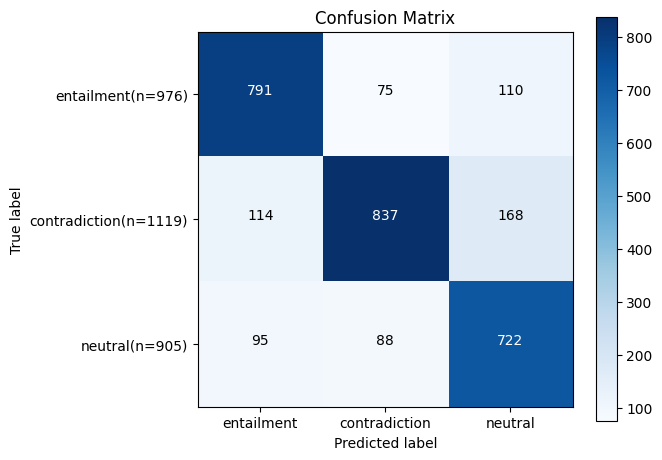

In [34]:
trainer.test()